* https://sararobinson.dev/2020/01/15/fraud-detection-tensorflow.html
* Dataset -> https://www.kaggle.com/ntnu-testimon/paysim1

In [1]:
import pandas as pd
from sklearn.utils import shuffle

import tensorflow as tf
tf.random.set_seed(123)
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
data_file = '/Users/robin/kaggle/Synthetic Financial Datasets For Fraud Detection/PS_20174392719_1491204439457_log.csv'

In [3]:
data = pd.read_csv(data_file)

In [4]:
data.shape[0]/1e6

6.36262

6.3M rows sounds great, right? In this case more data is not necessarily better. If I shove the data into a model as is, chances are the model will reach 99.9% accuracy by guessing every transaction is not a fraudulent one simply because 99.9% of the data is non fraudulent cases.

There are a few different approaches for dealing with imbalanced data, and I’m open to feedback on the approach I’m going with. To balance things out, I took all 8k of the fraudulent cases from the dataset along with a random sample of ~31k of the not fraud cases:

In [5]:
# Split into separate dataframes for fraud / not fraud
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

In [6]:
df = df.drop(columns = ['nameOrig', 'nameDest'])

In [7]:
df.shape[0]/1e3

39.985

The resulting dataset contains 25% fraud cases with a total of ~40k rows. Much better. I’ve also removed the transaction ID fields from the original Kaggle dataset. Here’s a snapshot of the data we’ll be working with:

In [8]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5777870,400,PAYMENT,65839.41,0.00,0.00,0.0,0.0,0,0
6362412,726,TRANSFER,561446.32,561446.32,0.00,0.0,0.0,1,0
5927827,404,PAYMENT,3828.08,10455.17,6627.09,0.0,0.0,0,0
5987904,410,TRANSFER,557950.06,557950.06,0.00,0.0,0.0,1,0
5706694,398,PAYMENT,1376.57,368349.14,366972.57,0.0,0.0,0,0


In [9]:
rows = df.shape[0]
rows

39985

In [10]:
train_eval_split = 0.7

Get train and evaluate sets

In [11]:
dftrain = df.iloc[:int(train_eval_split*rows)]
dfeval = df.iloc[int(train_eval_split*rows):]
y_train = dftrain.pop('isFraud') # Return item and drop from frame.
y_eval = dfeval.pop('isFraud')

## Building a boosted tree model with TensorFlow

Tree-based model have been shown to be effective for anomaly detection, which is what I’ll be using here. To my amazement, I only recently discovered that TensorFlow has a boosted tree classifier. There’s a great tutorial on it [here](https://www.tensorflow.org/tutorials/estimator/boosted_trees), which is mostly what I followed to build the model.

**Boosted Trees models are popular with many machine learning practitioners as they can achieve impressive performance with minimal hyperparameter tuning.**

Here are the numeric and categorical columns I’m using to build each tf.feature_column:

In [12]:
CATEGORICAL_COLUMNS = ['type']
NUMERIC_COLUMNS = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

fc = tf.feature_column

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

In [13]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))

In [14]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='type', vocabulary_list=('PAYMENT', 'TRANSFER', 'CASH_IN', 'CASH_OUT', 'DEBIT'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='step', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='amount', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldbalanceOrg', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='newbalanceOrig', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldbalanceDest', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='newbalanceDest', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [15]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

Next, it’s time to define our estimator. We can do this in one line of code:

In [16]:
model = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/th/p79ctr092t9c_795pyl79n6c0000gn/T/tmpliib8n24', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a316d0208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions f

And train it in another:

In [17]:
# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
model.train(train_input_fn, max_steps=100)

# Eval.
result = model.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.993414
accuracy_baseline         0.799683
auc                       0.998926
auc_precision_recall      0.997807
average_loss              0.026091
label/mean                0.200317
loss                      0.026091
precision                 0.972742
prediction/mean           0.201129
recall                    0.995006
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/th/p79ctr092t9c_795pyl79n6c0000gn/T/tmpliib8n24/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


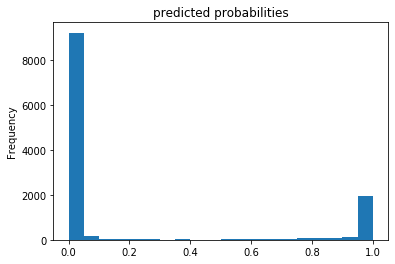

In [18]:
pred_dicts = list(model.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

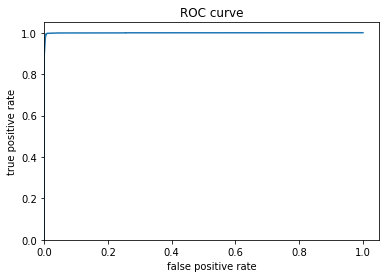

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

The article goes on to deploy the model to Google Cloud AI Platform and make use of [Explainable AI](https://cloud.google.com/explainable-ai/)